## IN3050/IN4050 Mandatory Assignment 2, 2023: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website:

- https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html 

in particular the paragraph on cooperation. This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": 
- https://www.uio.no/english/studies/examinations/cheating/index.html 

By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, March 24, 2023, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

#### Alternative 1
If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution which shows the results of the runs. (If you can't export: notebook -> latex -> pdf on your own machine, you may do this on the IFI linux machines.)

#### Alternative 2
If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Here is a list of *absolutely necessary* (but not sufficient) conditions to get the assignment marked as passed:

- You must deliver your code (python file or notebook) you used to solve the assignment.
- The code used for making the output and plots must be included in the assignment. 
- You must include example runs that clearly shows how to run all implemented functions and methods.
- All the code (in notebook cells or python main-blocks) must run. If you have unfinished code that crashes, please comment it out and document what you think causes it to crash. 
- You must also deliver a pdf of the code, outputs, comments and plots as explained above.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

### Goals of the assignment
The goal of this assignment is to get a better understanding of supervised learning with gradient descent. It will, in particular, consider the similarities and differences between linear classifiers and multi-layer feed forward networks (multi-layer perceptron, MLP) and the differences and similarities between binary and multi-class classification. A main part will be dedicated to implementing and understanding the backpropagation algorithm. 

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

The given precode uses NumPy. You are recommended to use NumPy since it results in more compact code, but feel free to use pure python if you prefer. 

### Beware
There might occur typos or ambiguities. This is a revised assignment compared to earlier years, and there might be new typos. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your own and explain them!

### Initialization

In [274]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn #for datasets

## Datasets

We start by making a synthetic dataset of 2000 datapoints and five classes, with 400 individuals in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(2022)`.

In [275]:
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[400,400,400, 400, 400], 
                        centers=[[0,1],[4,2],[8,1],[2,0],[6,0]], 
                        cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5],
                        n_features=2, random_state=2022)

In [276]:
indices = np.arange(X.shape[0])
rng = np.random.RandomState(2022)
rng.shuffle(indices)

In [277]:
X_train = X[indices[:1000],:]
X_val = X[indices[1000:1500],:]
X_test = X[indices[1500:],:]
t_multi_train = t_multi[indices[:1000]]
t_multi_val = t_multi[indices[1000:1500]]
t_multi_test = t_multi[indices[1500:]]

Next, we will  make a second dataset by merging classes in (X,t) into two classes and call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [278]:
t2_train = t_multi_train >= 3
t2_train = t2_train.astype('int')
t2_val = (t_multi_val >= 3).astype('int')
t2_test = (t_multi_test >= 3).astype('int')

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

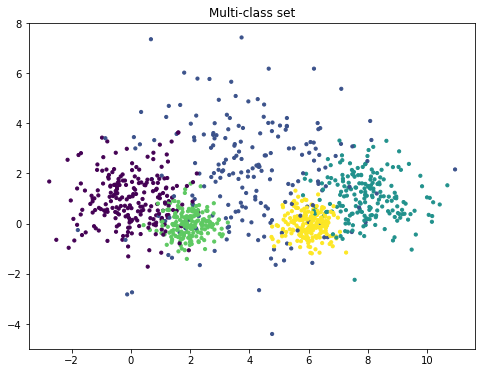

In [279]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title('Multi-class set')

Text(0.5, 1.0, 'Binary set')

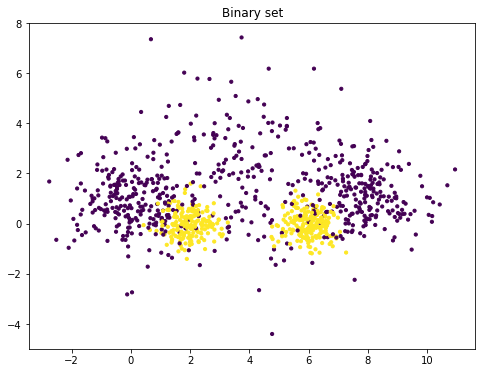

In [280]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title('Binary set')

# Part I: Linear classifiers
## Linear regression

We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may make your own implementation from scratch or start with the solution to the weekly exercise set 7. 
We include it here with a little added flexibility.

In [281]:
def add_bias(X, bias):
    """X is a Nxm matrix: N datapoints, m features
    bias is a bias term, -1 or 1. Use 0 for no bias
    Return a Nx(m+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1))*bias # Make a N*1 matrix of bias-s
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [282]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""

In [283]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias


    def fit(self, X_train, t_train, eta = 0.078, epochs=105):
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the targets values for the training data"""

        if self.bias:
            X_train = add_bias(X_train, self.bias)

        (N, m) = X_train.shape

        self.weights = weights = np.zeros(m)
        loss = []
        accuracy = []
        for e in range(epochs):
            y_pred = np.array(X_train @ weights)

            grad = 1 / N *  X_train.T @ (y_pred - t_train)
            weights -= eta * grad

            y_pred_label = y_pred > 0.5
            acc = np.mean(y_pred_label == t_train)
            MSE = (1 / N) * np.sum((y_pred - t_train)**2)

            accuracy.append(acc)
            loss.append(MSE)

        return np.asarray(loss), np.asarray(accuracy)


    def predict(self, X, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)

        print(X.shape, self.weights.shape)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier.

In [284]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [285]:

# using this loop we found the optimal eta and epoch values
'''
N = 100
eta_a = np.linspace(0.001, 0.1, N)
M = 10
epochs_a = np.linspace(10, 2000, M, dtype=int)

Acc = np.zeros((N, N))
for i in range(N):
    for j in range(M):
        cl = NumpyLinRegClass()
        cl.fit(X_train, t2_train, eta_a[i], epochs_a[j])
        Acc[i][j] = accuracy(cl.predict(X_val), t2_val)
print(np.max(Acc))
idx = np.where(Acc == np.max(Acc))
print(eta_a[idx[0]], epochs_a[idx[1]])
'''

cl_best = NumpyLinRegClass()
cl_best.fit(X_train, t2_train, eta=0.078, epochs=231)
print(accuracy(cl_best.predict(X_val), t2_val))

(500, 3) (3,)
0.736


The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [286]:
def plot_decision_regions(X, t, clf=[], size=(8,6)):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a make of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'Paired')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='Paired')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision regions")
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

(359170, 3) (3,)


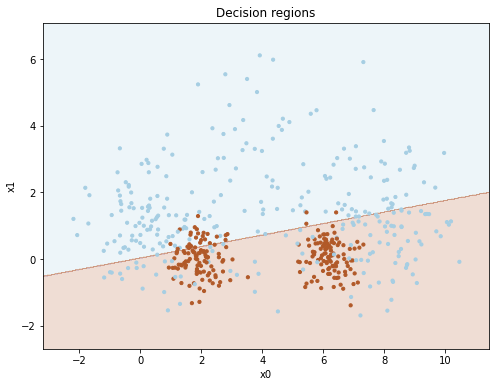

In [287]:
plot_decision_regions(X_val, t2_val, cl_best)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, *eta* and *epochs*, to get the best accuracy on the validation set. 

Report how the accuracy vary with the hyper-parameter settings. It is not sufficient to give the final hyperparemters. You must also show how you found them  and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

### Task: Loss
The linear regression classifier is trained with mean squared error loss. So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. 

Also extend the classifier to calculate the accuracy on the training data after each epoch.

Train a classifier with your best settings from last point. After training, plot the loss as a function of the number of epochs. Then plot the accuracy as a function of the number of epochs.

Comment on what you see: Are the function monotone? Is this as expected?

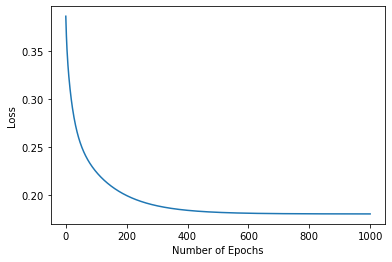

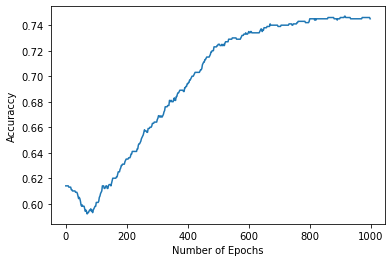

In [288]:
def PlotLossAndAccuracy(loss, acc, N):
    epochs = np.linspace(0, N, N, dtype=int)
    plt.plot(epochs, loss)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.plot(epochs[::2], acc[::2])
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuraccy')
    plt.show()

N=1000
cl_best_loss = NumpyLinRegClass()
loss, acc = cl_best_loss.fit(X_train, t2_train, eta=0.078, epochs=N)
PlotLossAndAccuracy(loss, acc, N)

### Task: Scaling

we have seen in the lectures that scaling the data may improve training speed. 

- Implement a scaler, either standard scaler (normalizer) or max-min scaler 
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up  the training.
- Report final hyper-meter settings and show how you found them.
- Plot the loss curve and the accuracy curve for the classifier trained on scaled data with the best settings you found.

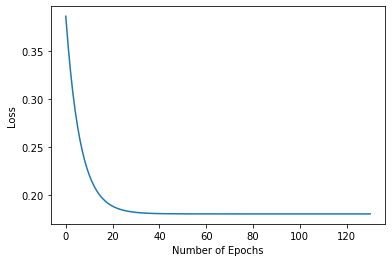

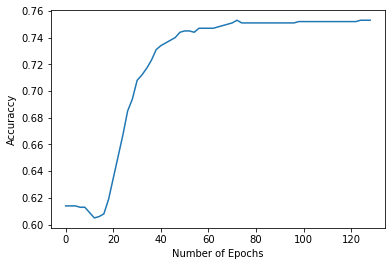

(122584, 3) (3,)


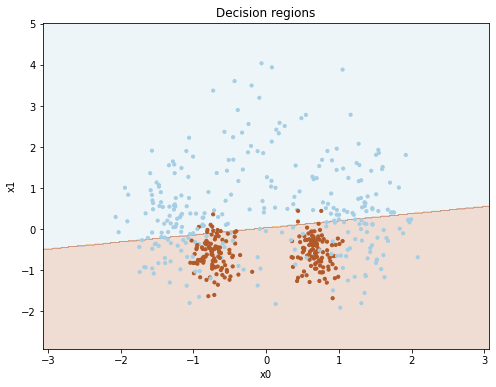

In [289]:
def scale_features(X_train):  # using standard scaling

    means = np.mean(X_train, axis=0)
    stds = np.std(X_train, axis=0)
    X_train_scaled = (X_train - means) / stds

    return X_train_scaled

X_train_scale = scale_features(X_train)

N=130
cl_best_scale = NumpyLinRegClass()
loss_best_scale, acc_best_scale = cl_best_scale.fit(X_train_scale, t2_train, eta=0.078, epochs=N)
PlotLossAndAccuracy(loss_best_scale, acc_best_scale, N)

X_val_scale = scale_features(X_val)

plot_decision_regions(X_val_scale, t2_val, cl_best)




## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use code from the solution to weekly exercise set week07.

b) In addition to the method `predict` which predicts a class for the data, include a method `predict_probability` which predicts the probability of the data belonging to the positive class.

c) As with the classifier based on linear regression, we want to calculate loss and accuracy after each epoch.
The prefered loss for logistic regression is binary cross-entropy. You could have used mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.

d) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch. 

e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit-method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after running `n_epochs_no_update` epochs. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

f) Train classifiers with various learning rates, and with varying values for `tol` for finding optimal values. Also consider the effect of scaling the data.

g) After a succesful training, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

In [290]:
class NumpyLogReg(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias

    def forward(self, x):  # using logistic function
        return self.logistic(x @ self.weights)

    def logistic(self, x):
        return 1/(1+np.exp(-x))

    def fit(self, X_train, t_train, tol, n_epochs_no_update=5, X_val=None, t_val=None, eta = 0.4902, epochs=1000):
        """X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N,
        the targets values for the training data"""

        if self.bias:
            X_train = add_bias(X_train, self.bias)
            if X_val is not None:
                X_val = add_bias(X_val, self.bias)

        (N, m) = X_train.shape
        self.weights = weights = np.zeros(m)
        train_loss = []
        train_accuracy = []
        val_loss = []
        val_accuracy = []
        n_epochs_ran = 0  # counter for how many epochs were ran
        for i in range(epochs):
            n_epochs_ran += 1

            # training of the weights
            grad = 1/ N *  X_train.T @ (self.forward(X_train) - t_train)
            weights -= eta * grad

            # calculating accuracy and loss per epoch
            y_pred_label = self.forward(X_train) > 0.5
            acc = np.mean(y_pred_label == t_train)
            MSE = (1 / N) * np.sum((self.forward(X_train) - t_train)**2)


            train_accuracy.append(acc)
            train_loss.append(MSE)

            # if validation set is given, calculating the accuracy and loss on that set using the trained weights
            if X_val is not None:
                y_pred_label = self.forward(X_val) > 0.5
                acc = np.mean(y_pred_label == t_val)
                MSE = (1 / N) * np.sum((self.forward(X_val) - t_val)**2)


                val_accuracy.append(acc)
                val_loss.append(MSE)

            # if the loss doesnt improve by tol after n_epochs_no_update epochs, the program stops.
            if i > n_epochs_no_update and (train_loss[i] - (train_loss[i-n_epochs_no_update]) >= tol):
                break

        #print(f'Number of epochs the program was trained over: {n_epochs_ran}')

        # if validation set is given, returns 4 arrays, if not, returns 2
        if X_val is None:
            return np.asarray(train_accuracy), np.array(train_loss)
        else:
            return np.asarray(train_accuracy), np.array(train_loss), np.asarray(val_accuracy), np.array(val_loss)


    def predict(self, x, threshold=0.5):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(x, self.bias)

            return (self.forward(X) > threshold).astype('int')

        else:
            return (self.forward(x) > threshold).astype('int')


    def predict_probability(self, x):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(x, self.bias)

            return self.forward(X)

        else:
            return self.forward(x)


0.778
0.778


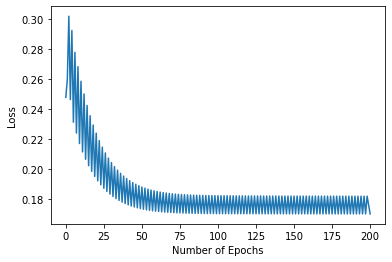

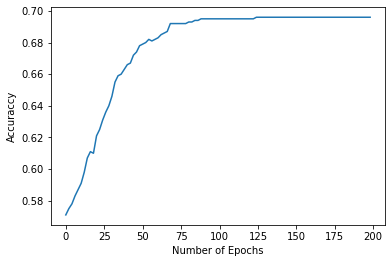

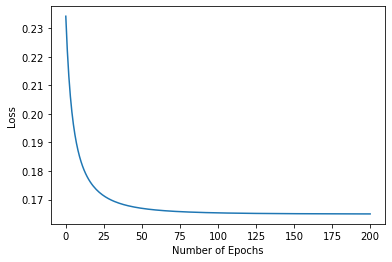

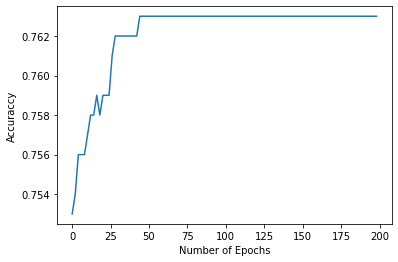

In [291]:
lr_cl = NumpyLogReg()
train_accuracy, train_loss = lr_cl.fit(X_train, t2_train, tol=0.29, epochs=200)
print(accuracy(lr_cl.predict(X_val), t2_val))
#lr_cl.predict_probability(X_val, t2_val)

PlotLossAndAccuracy(train_loss, train_accuracy, 200)

lr_cl_scale = NumpyLogReg()
log_scale_acc, log_scale_loss = lr_cl_scale.fit(X_train_scale, t2_train, tol=0.29, epochs=200)
print(accuracy(lr_cl.predict(X_val), t2_val))

PlotLossAndAccuracy(log_scale_loss, log_scale_acc, 200)


In [292]:

for eta in np.linspace(0.0001, 1, 150):
    lr_cl = NumpyLogReg()
    lr_cl.fit(X_train, t2_train, eta=eta, tol=0.29, epochs=200)
    print("Learning rate: {} Epochs: {:7} Accuracy: {}".format(
    eta, 1000, accuracy(lr_cl.predict(X_val), t2_val)))

# All of the best accuracy values seem to be around 0.5. I've tried going down to 0.0001
# but the accuracy just got worse the lower i went. I'm not sure if it's worth lowering the
# accuracy just to get a better plot.

'''
for tol in np.linspace(0.02, 0.03, 20):
    lr_cl = NumpyLogReg()
    lr_cl.fit(X_train, t2_train, tol=tol)
    print(f'Tol: {tol} , Accuracy : {accuracy(lr_cl.predict(X_val), t2_val)}')
    print(f'\n')
'''

eta = 0.4902
tol = 0.028



Learning rate: 0.0001 Epochs:    1000 Accuracy: 0.544
Learning rate: 0.006810738255033557 Epochs:    1000 Accuracy: 0.61
Learning rate: 0.013521476510067113 Epochs:    1000 Accuracy: 0.666
Learning rate: 0.02023221476510067 Epochs:    1000 Accuracy: 0.678
Learning rate: 0.026942953020134226 Epochs:    1000 Accuracy: 0.686
Learning rate: 0.033653691275167784 Epochs:    1000 Accuracy: 0.684
Learning rate: 0.04036442953020134 Epochs:    1000 Accuracy: 0.69
Learning rate: 0.0470751677852349 Epochs:    1000 Accuracy: 0.692
Learning rate: 0.05378590604026846 Epochs:    1000 Accuracy: 0.69
Learning rate: 0.060496644295302014 Epochs:    1000 Accuracy: 0.694
Learning rate: 0.06720738255033556 Epochs:    1000 Accuracy: 0.696
Learning rate: 0.07391812080536912 Epochs:    1000 Accuracy: 0.698
Learning rate: 0.08062885906040268 Epochs:    1000 Accuracy: 0.7
Learning rate: 0.08733959731543624 Epochs:    1000 Accuracy: 0.702
Learning rate: 0.0940503355704698 Epochs:    1000 Accuracy: 0.704
Learning r

## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t_multi).

### "One-vs-rest" with logistic regression
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

In [293]:
class NumpyMulti(NumpyClassifier):

    def __init__(self, n_classes, bias=-1):
        self.bias = bias
        self.n_classes = n_classes

    def create_t(self, t_multi, class_num):
        '''
        Creates a binary t-set from a multi-class set, based on which class you are interested in.
        '''
        t_binary = t_multi.copy()

        for i in range(len(t_binary)):
            if t_binary[i] == class_num:
                t_binary[i] = 1
            else:
                t_binary[i] = 0

        return t_binary

    def fit(self, X_train, t_multi_train, tol=0.2, n_epochs_no_update=5, X_val=None, t_val=None, eta=0.01, epochs=1000):
        if self.bias:
            X_train_bias = add_bias(X_train, self.bias)
            if X_val:
                X_val = add_bias(X_val, self.bias)

        (N, m) = X_train_bias.shape
        self.weights = np.zeros((m, self.n_classes))

        train_loss = []
        train_accuracy = []
        for i in range(self.n_classes):
            # Create new targets for current class using one-vs-rest
            t_train_binary = self.create_t(t_multi_train, class_num=i)

            # Train model for current class
            model = NumpyLogReg()
            accuracy, loss = model.fit(X_train=X_train, t_train=t_train_binary, tol=tol, n_epochs_no_update=n_epochs_no_update, eta=eta, epochs=epochs)
            #print(accuracy)
            self.weights[:, i] = model.weights

            train_accuracy.append(accuracy)
            train_loss.append(loss)

        Acc = np.asarray(train_accuracy)
        loss = np.asarray(train_loss)

        return Acc, loss

    def predict(self, x):
        if self.bias:
            X = add_bias(x, self.bias)
        #print(self.weights)
        #print(X.shape, self.weights.shape)

        scores = X @ self.weights  # Compute scores for all classes using dot product


        return np.argmax(scores, axis=1)  # Return class with highest score for each data point

0.67


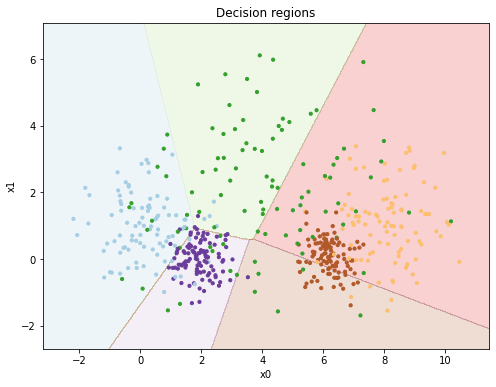

In [294]:
N = 200
mult = NumpyMulti(n_classes=5)
acc, loss = mult.fit(X_train, t_multi_train, tol=0.2, epochs=N, eta=0.4902)


print(accuracy(mult.predict(X_val), t_multi_val))
plot_decision_regions(X_val, t_multi_val, mult)

I am having an error that I can't solve. "model.weights", which is the instance of the LogReg I call on in the loop, is spitting out
4 weights instead of 3, and I have no idea how this is happening. I've spent a great deal of time trying to troubleshooot this.
I will hopefully be able to fix it on the second attempt.

### For in4050-students: Multi-nominal logistic regression
The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. Everybody has to return for the part 2 on multi-layer neural networks. 

In the lecture, we contrasted the one-vs-rest approach with the multinomial logistic regression, also called softmax classifier. Implement also this classifier, tune the parameters, and compare the results to the one-vs-rest classifier. 

Remember that this classifier uses softmax in the forward phase. For loss, it uses categorical cross-entropy loss. The loss has a somewhat simpler form than in the binary case. To calculate the gradient is a little more complicated. The actual gradient and update rule is simple, however, as long as you have calculated the forward values correctly.

# Part II Multi-layer neural networks

## A first non-linear classifier

The following code it a simple implementation of a multi-layer perceptron.
It is quite restricted.
There is only one hidden layer.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

It can be used to make a non-linear classifier for the set (X, t2).
Experiment with settings for learning rate and epochs and see how good results you can get.
Report results for variouse settings.
Be prepared to train for a looooong time.
Plot the training set together with the decision regions as in part I.

In [295]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        self.dim_hidden = dim_hidden
        
        def logistic(x):
            return 1/(1+np.exp(-x))

        self.activ = logistic
        
        def logistic_diff(y):
            return y * (1 - y)
        self.activ_diff = logistic_diff
        
    def fit(self, X_train, t_train, X_val=None, t_val=None, eta=0.001, epochs = 100, tol=None, n_epochs_no_update=None):
        """Intialize the weights. Train *epochs* many epochs.
        
        X_train is a Nxm matrix, N data points, m features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        """
        self.eta = eta
        
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)

        X_train_bias = add_bias(X_train, self.bias)

        train_loss = []
        train_acc = []
        val_loss = []
        val_acc = []
        n_epochs_ran = 0  # counter for how many epochs were ran
        for e in range(epochs):
            n_epochs_ran += 1

            # One epoch
            hidden_outs, outputs = self.forward(X_train_bias)
            # The forward step
            out_deltas = (outputs - T_train)
            # The delta term on the output node
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The delta terms at the output of the hidden layer
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:]))
            # The deltas at the input to the hidden layer
            self.weights2 -= self.eta * hidden_outs.T @ out_deltas
            self.weights1 -= self.eta * X_train_bias.T @ hiddenact_deltas 
            # Update the weights

            y_pred_label = self.predict(X_train)
            acc = np.mean(y_pred_label == t_train)

            prob = self.predict_probability(X_train)
            loss = -np.sum(t_train * np.log(prob) + (1 - t_train) * np.log(1 - prob)) # cross entropy loss

            train_acc.append(acc)
            train_loss.append(loss)

            # if validation set is given, calculating the accuracy and loss on that set using the trained weights
            if X_val is not None:
                y_pred_label = self.forward(X_val) > 0.5
                acc = np.mean(y_pred_label == t_val)
                val_loss = -np.sum(t2_val * np.log(X_val))  # cross entropy loss

                val_acc.append(acc)
                val_loss.append(val_loss)

            # if the loss doesnt improve by tol after n_epochs_no_update epochs, the program stops.
            if n_epochs_no_update:
                if e > n_epochs_no_update and (train_loss[e] - (train_loss[e-n_epochs_no_update]) >= tol):
                    break

        print(f'Number of epochs the program was trained over: {n_epochs_ran}')

        # if validation set is given, returns 4 arrays, if not, returns 2
        if X_val is None:
            return np.asarray(train_acc), np.array(train_loss)
        else:
            return np.asarray(train_acc), np.array(train_loss), np.asarray(val_acc), np.array(val_loss)

            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        hidden_activations = self.activ(X @ self.weights1)
        hidden_outs = add_bias(hidden_activations, self.bias)
        outputs = hidden_outs @ self.weights2
        return hidden_outs, outputs
    
    def predict(self, X):
        """Predict the class for the members of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return score > 0.5

    def predict_probability(self, x):
        """X is a Kxm matrix for some K>=1
        predict the value for each point in X"""
        X = add_bias(x, self.bias)
        forw = self.forward(X)[1]
        score= forw[:, 0]
        prob = self.activ(score)

        return prob


Number of epochs the program was trained over: 9931
5 5


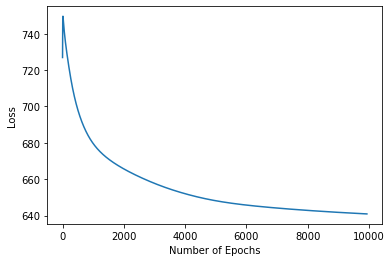

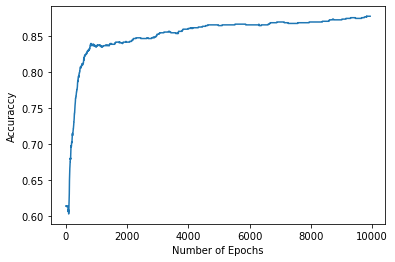

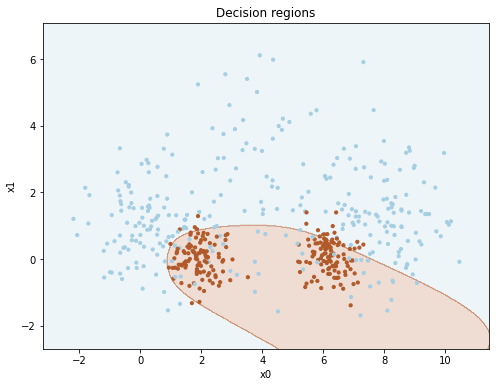

In [296]:
'''for i in np.linspace( 5.2631578947368424e-05, 9.526315789473685e-05, 30):            '''
'''    model = MLPBinaryLinRegClass()                                                   '''
'''    model.fit(X_train, t2_train, i, 1000)                                            '''
'''    print(f'Eta: {i} , Accuracy : {accuracy(model.predict(X_val), t2_val)}')         '''

best_eta = 8.791288566243195e-05

'''for i in np.linspace(8000, 15_000, 30, dtype=int):                               '''
'''    model = MLPBinaryLinRegClass()                                               '''
'''    model.fit(X_train, t2_train, best_eta, i)                                    '''
'''    print(f'Epochs: {i} , Accuracy : {accuracy(model.predict(X_val), t2_val)}')  '''

best_epoch = 9931

'''
for i in np.linspace(0.001, 0.01, 20):
    model = MLPBinaryLinRegClass()
    model.fit(X_train, t2_train, best_eta, best_epoch, tol=i, n_epochs_no_update=5)
    print(f'Epochs: {i} , Accuracy : {accuracy(model.predict(X_val), t2_val)}')
'''

'''
for i in np.linspace(1, 10, 9, dtype=int):
    model = MLPBinaryLinRegClass(dim_hidden=i)
    model.fit(X_train, t2_train, best_eta, best_epoch)
    print(f'Epochs: {i} , Accuracy : {accuracy(model.predict(X_val), t2_val)}')
'''

N = best_epoch
model = MLPBinaryLinRegClass()
NN_acc, NN_loss = model.fit(X_train, t2_train, eta=best_eta, epochs=N)
print(len(loss), len(acc))
PlotLossAndAccuracy(NN_loss, NN_acc, N)
plot_decision_regions(X_val, t2_val, model)

## Improving the classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the method predict, which predicts a class for the data, include a method predict_probability which predict the probability of the data belonging to the positive class. The training should be based on this value as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) In addition, extend the fit-method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to fit, calculate the loss and the accuracy for the validation set after each epoch.

d) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the fit method with two keyword arguments, `tol` and `n_epochs_no_update` and stop training when the loss has not improved with more than tol after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 5. Also, add an attribute to the classifier which tells us after fitting how many epochs were ran.

e) Tune the hyper-parameters:`eta`, `tol`and `dim-hidden`.
Also consider the effect of scaling the data.

f) After a succesful training with a best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both accuracies as functions of the number of epochs in another figure. Comment on what you see.

g) The algorithm contains an element of non-determinism. Hence, train the classifier 10 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 10 runs.

## For IN4050-students: Multi-class neural network

The following part is only mandatory for in4050-students. In3050-students are also welcome to make it a try. (This is the most fun part of the set :) )

The goal is to use a feed-forward network for non-linear multi-class classfication and apply it to set (X, t_multi).

Modify the netork to become a multi-class classifier. As a check of your implementation, you may apply it to (X, t_2) and see whether you get similar results as above.

Train the resulting classifier on (X_train, t_multi_train), test it on (X_val, t_multi_val), tune the hyper-parameters and report the accuracy.

Plot the decision boundaries for your best classifier.

# Part III: Final testing
We can now perform a final testing on the held-out test set.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and calculate accuracy on the held-out test set, but also on the validation set and the training set. Report in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different data sets. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation data. Is that the case here? 

Also report precision and recall for class 1.

In [297]:
import pandas as pd

# calling on, training, and calculating accuracy of LinearRegression
lin_cl = NumpyLinRegClass()
lin_cl.fit(X_train, t2_train, eta=0.078, epochs=231)

lin_train_acc = accuracy(lin_cl.predict(X_train), t2_train)
lin_val_acc = accuracy(lin_cl.predict(X_val), t2_val)
lin_test_acc = accuracy(lin_cl.predict(X_test), t2_test)


# calling on, training, and calculating accuracy of LogRegression
log_cl = NumpyLogReg()
log_cl.fit(X_train, t2_train, tol=0.29, epochs=200)

log_train_acc = accuracy(log_cl.predict(X_train), t2_train)
log_val_acc = accuracy(log_cl.predict(X_val), t2_val)
log_test_acc = accuracy(log_cl.predict(X_test), t2_test)


# calling on, training, and calculating accuracy of Multi-layer neural network
NN_cl = MLPBinaryLinRegClass()
NN_cl.fit(X_train, t2_train, eta=best_eta, epochs=N)

NN_train_acc = accuracy(NN_cl.predict(X_train), t2_train)
NN_val_acc = accuracy(NN_cl.predict(X_val), t2_val)
NN_test_acc = accuracy(NN_cl.predict(X_test), t2_test)


# creating table
data = {'Lin': [lin_train_acc, lin_val_acc, lin_test_acc], 'Log': [log_train_acc, log_val_acc, log_test_acc],
        'NN': [NN_train_acc, NN_val_acc, NN_test_acc]}
rows = ['Train', 'Val', 'Test']
df = pd.DataFrame(data, index=rows)
print(df)

(1000, 3) (3,)
(500, 3) (3,)
(500, 3) (3,)
Number of epochs the program was trained over: 9931
         Lin    Log     NN
Train  0.738  0.756  0.859
Val    0.736  0.778  0.848
Test   0.712  0.720  0.844


My logistic regression is slightly better than my linear regression, although i would expect it to perform even better.
The neural network performs much better as to be expected.

## For IN4050-students: Multi-class task (X, t_multi)
The following part is only mandatory for in4050-students. In3050-students are also welcome to do it. It requires the earlier IN4050-only tasks. 

Compare the three multi-class classifiers, the one-vs-rest and the multinomial logistic regression from part one, and the multi-class neural network from part two. Evaluate on test, validation and training set as above.

Comment on what you see